In [6]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append(os.path.abspath(os.pardir))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# %reset
from sympy import symbols, init_printing, simplify, solve, srepr, Add, Symbol, Integer, Float, pi, cos, sin, Rational
from sympy import IndexedBase, Eq, simplify, sqrt, latex
from mako.template import Template
from mako.lookup import TemplateLookup
from mako.runtime import Context
from StringIO import StringIO
from opesci import *
init_printing()

In [53]:
Mx = SField('Mx', dimension=3, direction=(1, 1))
My = SField('My', dimension=3, direction=(1, 1))
Mz = SField('Mz', dimension=3, direction=(1, 1))

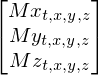

In [95]:
M = Matrix([Mx[t,x,y,z],My[t,x,y,z],Mz[t,x,y,z]]); M

In [10]:
H_eff = Matrix([0,0,1]);H_eff

In [11]:
t, x,y,z = symbols('t x y z')

In [12]:
dt, h = symbols('dt h')

In [55]:
Mx.set_indices([t,x,y,z])
My.set_indices([t,x,y,z])
Mz.set_indices([t,x,y,z])

In [56]:
Mx.set_spacing([dt,h,h,h])
My.set_spacing([dt,h,h,h])
Mz.set_spacing([dt,h,h,h])

In [57]:
Mx.set_accuracy([1,1,1,1])
My.set_accuracy([1,1,1,1])
Mz.set_accuracy([1,1,1,1])

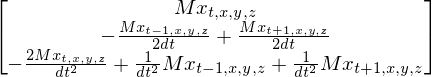

In [58]:
Deriv(Mx,[t,x,y,z],0,dt,2)

In [59]:
Mx.populate_derivatives(max_order=2)
My.populate_derivatives(max_order=2)
Mz.populate_derivatives(max_order=2)

In [60]:
Mx.d

[[None, D_Mx_t_1, D_Mx_t_2],
 [None, D_Mx_x_1, D_Mx_x_2],
 [None, D_Mx_y_1, D_Mx_y_2],
 [None, D_Mx_z_1, D_Mx_z_2]]

In [74]:
gamma, lam = symbols('gamma lambda')
A, mu0, Ms, K = symbols('A mu_0 Ms K')
e = Matrix([1,1,1])
H = Matrix([1,1,1])

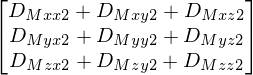

In [75]:
M_laplace = Matrix([Mx.d[1][2]+Mx.d[2][2]+Mx.d[3][2],My.d[1][2]+My.d[2][2]+My.d[3][2],Mz.d[1][2]+Mz.d[2][2]+Mz.d[3][2]])
M_laplace

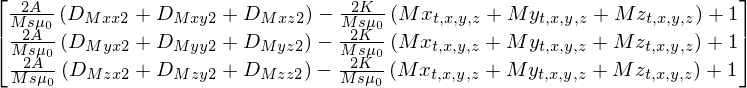

In [98]:
H_eff = 2*A/mu0/Ms*M_laplace - 2*K/mu0/Ms*(M.dot(e))*e + H
H_eff

In [82]:
Mx.d

[[None, D_Mx_t_1, D_Mx_t_2],
 [None, D_Mx_x_1, D_Mx_x_2],
 [None, D_Mx_y_1, D_Mx_y_2],
 [None, D_Mx_z_1, D_Mx_z_2]]

In [99]:
eq11 = Eq(Mx.d[0][1], (-gamma*(M.cross(H_eff)) - lam*M.cross(M.cross(H_eff)))[0])
eq12 = Eq(My.d[0][1], (-gamma*(M.cross(H_eff)) - lam*M.cross(M.cross(H_eff)))[1])
eq13 = Eq(Mz.d[0][1], (-gamma*(M.cross(H_eff)) - lam*M.cross(M.cross(H_eff)))[2])

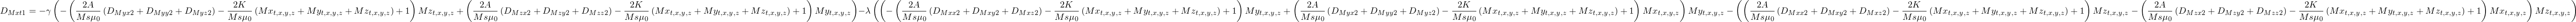

In [100]:
eq11

In [88]:
Mx.d[1][1].fd[1]

[None, -Mx[t, x - 1, y, z]/(2*h) + Mx[t, x + 1, y, z]/(2*h)]

In [101]:
dict1 = {}
for deriv in get_all_objects(eq11,DDerivative):
    dict1[deriv] = deriv.fd[1]

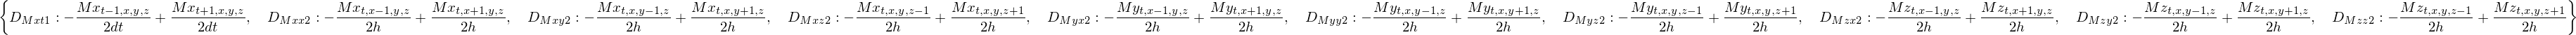

In [90]:
dict1

In [102]:
eq11 = eq11.subs(dict1)

In [104]:
lhs = Mx[t+1,x,y,z]
kernel = solve(eq11,lhs)[0]

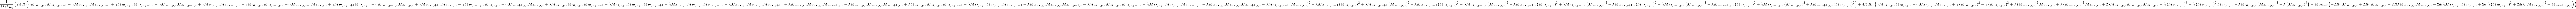

In [105]:
kernel

In [106]:
ccode(kernel)

'(2*A*dt*(gamma*My[t][x][y][z]*Mz[t][x][y][z - 1] - gamma*My[t][x][y][z]*Mz[t][x][y][z + 1] + gamma*My[t][x][y][z]*Mz[t][x][y - 1][z] - gamma*My[t][x][y][z]*Mz[t][x][y + 1][z] + gamma*My[t][x][y][z]*Mz[t][x - 1][y][z] - gamma*My[t][x][y][z]*Mz[t][x + 1][y][z] - gamma*My[t][x][y][z - 1]*Mz[t][x][y][z] + gamma*My[t][x][y][z + 1]*Mz[t][x][y][z] - gamma*My[t][x][y - 1][z]*Mz[t][x][y][z] + gamma*My[t][x][y + 1][z]*Mz[t][x][y][z] - gamma*My[t][x - 1][y][z]*Mz[t][x][y][z] + gamma*My[t][x + 1][y][z]*Mz[t][x][y][z] + lambda*Mx[t][x][y][z]*My[t][x][y][z]*My[t][x][y][z - 1] - lambda*Mx[t][x][y][z]*My[t][x][y][z]*My[t][x][y][z + 1] + lambda*Mx[t][x][y][z]*My[t][x][y][z]*My[t][x][y - 1][z] - lambda*Mx[t][x][y][z]*My[t][x][y][z]*My[t][x][y + 1][z] + lambda*Mx[t][x][y][z]*My[t][x][y][z]*My[t][x - 1][y][z] - lambda*Mx[t][x][y][z]*My[t][x][y][z]*My[t][x + 1][y][z] + lambda*Mx[t][x][y][z]*Mz[t][x][y][z]*Mz[t][x][y][z - 1] - lambda*Mx[t][x][y][z]*Mz[t][x][y][z]*Mz[t][x][y][z + 1] + lambda*Mx[t][x][y][z]*

In [108]:
add, mul, arrays = get_ops_expr(kernel, arrays)
store = 1

In [110]:
print add, mul, arrays

53 161 ['My', 'Mz', 'Mx']


In [112]:
(53+161)/4/4

In [31]:
eq1 = Eq(Mx.d[0][1], -Mx[t,x,y,z]*Mz[t,x,y,z]*lam - My[t,x,y,z]*gamma)
eq2 = Eq(My.d[0][1], Mx[t,x,y,z]*gamma - My[t,x,y,z]*Mz[t,x,y,z]*lam)
eq3 = Eq(Mz.d[0][1], -lam*(-Mx[t,x,y,z]*Mx[t,x,y,z]-My[t,x,y,z]*My[t,x,y,z]))

In [39]:
fdeq1 = Eq(Mx.d[0][1].fd[1],  -Mx[t,x,y,z]*Mz[t,x,y,z]*lam - My[t,x,y,z]*gamma)
fdeq2 = Eq(My.d[0][1].fd[1], Mx[t,x,y,z]*gamma - My[t,x,y,z]*Mz[t,x,y,z]*lam)
fdeq3 = Eq(Mz.d[0][1].fd[1], -lam*(-Mx[t,x,y,z]*Mx[t,x,y,z]-My[t,x,y,z]*My[t,x,y,z]))

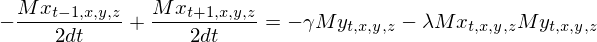

In [40]:
fdeq1

In [41]:
k1 = solve(fdeq1,Mx[t+1,x,y,z])[0]
k2 = solve(fdeq2,My[t+1,x,y,z])[0]
k3 = solve(fdeq3,Mz[t+1,x,y,z])[0]

In [42]:
k1

In [43]:
ccode(k1)

'-2*dt*gamma*My[t][x][y][z] - 2*dt*lambda*Mx[t][x][y][z]*My[t][x][y][z] + Mx[t - 1][x][y][z]'

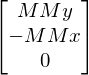

In [40]:
MMx, MMy, MMz = symbols('MMx MMy MMz')
M = Matrix([MMx,MMy,MMz])
M.cross(H_eff)

In [ ]:

Txx = SField('Txx', dimension=3, direction=(1, 1))
Tyy = SField('Tyy', dimension=3, direction=(2, 2))
Tzz = SField('Tzz', dimension=3, direction=(3, 3))
Txy = SField('Txy', dimension=3, direction=(1, 2))
Tyz = SField('Tyz', dimension=3, direction=(2, 3))
Txz = SField('Txz', dimension=3, direction=(1, 3))
U = VField('U', dimension=3, direction=1)
V = VField('V', dimension=3, direction=2)
W = VField('W', dimension=3, direction=3)

In [10]:
grid = StaggeredGrid(dimension=3, domain_size=(1.0, 1.0, 1.0), grid_size=(100, 100, 100), 
                     stress_fields=[Txx, Tyy, Tzz, Txy, Tyz, Txz], velocity_fields=[U, V, W])
grid.set_time_step(0.002, 1.0)
grid.set_switches(omp=True, simd=False, ivdep=True,
                  double=False, expand=True, eval_const=True)
grid.set_media_params(read=False, rho=1.0, vp=1.0, vs=0.5,
                      rho_file='RHOhomogx200', vp_file='VPhomogx200', vs_file='VShomogx200')
grid.get_time_step_limit()

####Analytical solutions
$U = cos(\pi x)(sin(\pi y)-sin(\pi z))cos(\Omega t)$<br>
$V = cos(\pi y)(sin(\pi z)-sin(\pi x))cos(\Omega t)$<br>
$W = cos(\pi z)(sin(\pi x)-sin(\pi y))cos(\Omega t)$<br>
$T_{xx} = -Asin(\pi x)(sin(\pi y)-sin(\pi z))sin(\Omega t)$<br>
$T_{yy} = -Asin(\pi y)(sin(\pi z)-sin(\pi x))sin(\Omega t)$<br>
$T_{zz} = -Asin(\pi z)(sin(\pi x)-sin(\pi y))sin(\Omega t)$<br>
$T_{xy} = T_{yz} = T_{xz} = 0$<br>
where $A=\sqrt{2\rho \mu} \space \space \Omega=\pi\sqrt{\frac{2\mu}{\rho}}$

In [11]:
rho, beta, lam, mu = symbols('rho beta lambda mu')
t, x, y, z = symbols('t x y z')
grid.set_index([x, y, z])

Omega = pi*sqrt(2*mu/rho)
A = sqrt(2*rho*mu)
U_func = cos(pi*x)*(sin(pi*y)-sin(pi*z))*cos(Omega*t)
V_func = cos(pi*y)*(sin(pi*z)-sin(pi*x))*cos(Omega*t)
W_func = cos(pi*z)*(sin(pi*x)-sin(pi*y))*cos(Omega*t)
Txx_func = -A*sin(pi*x)*(sin(pi*y)-sin(pi*z))*sin(Omega*t)
Tyy_func = -A*sin(pi*y)*(sin(pi*z)-sin(pi*x))*sin(Omega*t)
Tzz_func = -A*sin(pi*z)*(sin(pi*x)-sin(pi*y))*sin(Omega*t)
Txy_func = Float(0)
Tyz_func = Float(0)
Txz_func = Float(0)

In [12]:
U.set_analytic_solution(U_func)
V.set_analytic_solution(V_func)
W.set_analytic_solution(W_func)
Txx.set_analytic_solution(Txx_func)
Tyy.set_analytic_solution(Tyy_func)
Tzz.set_analytic_solution(Tzz_func)
Txy.set_analytic_solution(Txy_func)
Tyz.set_analytic_solution(Tyz_func)
Txz.set_analytic_solution(Txz_func)

In [13]:
grid.set_accuracy([1,2,2,2])
grid.calc_derivatives()

###PDEs
#####momentum equations
$\partial_tU = b(\partial_xT_{xx}+\partial_yT_{xy}+\partial_zT_{xz})$<br>
$\partial_tV = b(\partial_xT_{xy}+\partial_yT_{yy}+\partial_zT_{yz})$<br>
$\partial_tW = b(\partial_xT_{xz}+\partial_yT_{yz}+\partial_zT_{zz})$<br>
#####stress-strain equations
$\partial_tT_{xx} = (\lambda+2\mu)\partial_xU + \lambda(\partial_yV+\partial_zW)$<br>
$\partial_tT_{yy} = (\lambda+2\mu)\partial_yV + \lambda(\partial_xU+\partial_zW)$<br>
$\partial_tT_{zz} = (\lambda+2\mu)\partial_zW + \lambda(\partial_xU+\partial_yV)$<br>
$\partial_tT_{xy} = \mu(\partial_yU + \partial_xV)$<br>
$\partial_tT_{xz} = \mu(\partial_zU + \partial_xW)$<br>
$\partial_tT_{yz} = \mu(\partial_zV + \partial_yW)$<br>

In [14]:
# momentum equations
eq1 = Eq(U.d[0][1], beta*(Txx.d[1][1] + Txy.d[2][1] + Txz.d[3][1]))
eq2 = Eq(V.d[0][1], beta*(Txy.d[1][1] + Tyy.d[2][1] + Tyz.d[3][1]))
eq3 = Eq(W.d[0][1], beta*(Txz.d[1][1] + Tyz.d[2][1] + Tzz.d[3][1]))
# stress-strain equations
eq4 = Eq(Txx.d[0][1], (lam + 2*mu)*U.d[1][1] + lam*(V.d[2][1]+W.d[3][1]))
eq5 = Eq(Tyy.d[0][1], (lam + 2*mu)*V.d[2][1] + lam*(U.d[1][1]+W.d[3][1]))
eq6 = Eq(Tzz.d[0][1], (lam + 2*mu)*W.d[3][1] + lam*(U.d[1][1]+V.d[2][1]))
eq7 = Eq(Txy.d[0][1], mu*(U.d[2][1] + V.d[1][1]))
eq8 = Eq(Tyz.d[0][1], mu*(V.d[3][1] + W.d[2][1]))
eq9 = Eq(Txz.d[0][1], mu*(U.d[3][1] + W.d[1][1]))

In [15]:
grid.solve_fd([eq1,eq2,eq3,eq4,eq5,eq6,eq7,eq8,eq9])

In [16]:
grid.set_free_surface_boundary(dimension=1,side=0)
grid.set_free_surface_boundary(dimension=1,side=1)
grid.set_free_surface_boundary(dimension=2,side=0)
grid.set_free_surface_boundary(dimension=2,side=1)
grid.set_free_surface_boundary(dimension=3,side=0)
grid.set_free_surface_boundary(dimension=3,side=1)

###output using templates

In [12]:
# write to template file
# grid.generate('../tmp/test_deriv.cpp', False, True)

In [14]:
grid.get_velocity_kernel_ai()

In [15]:
grid.get_stress_kernel_ai()

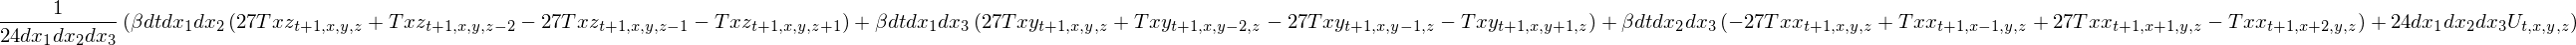

In [17]:
U.kernel_aligned

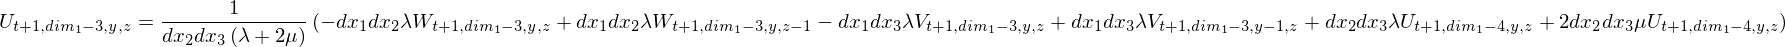

In [24]:
U.bc[1][1][0]